### Neural Nets From Scratch
Followed The guide at http://www.wildml.com/2015/09/implementing-a-neural-network-from-scratch/

In [1]:
import numpy as np 
import matplotlib.pyplot as plt
from sklearn.datasets import make_moons

### The Data
We will use one of SciKit Learns data sets for this example. 

In [2]:
np.random.seed(0)
X, y = make_moons(200, noise=0.20)

This data contains 200 exaples with two features, so $X\in\mathbb{R}^{200\times 2}$. The output `y` has two possible classes, so we only need one values to indicate which class it is in, thus $y\in \mathbb{R}^{200}$. We plot the data below and we can see that this data is _not_ linearly seperable, so we need something more complex than a linear method like regression. 

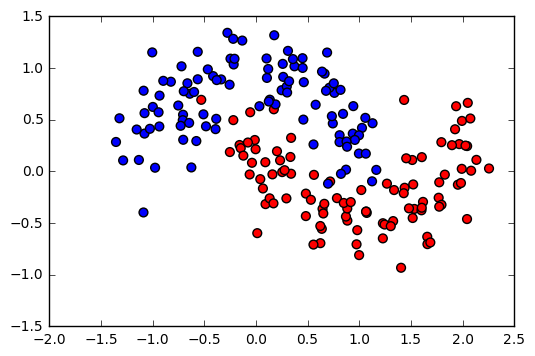

In [3]:
%matplotlib inline
plt.scatter(X[:,0], X[:,1], s=40, c=y, cmap=plt.cm.bwr)

### The Design of the Neural Net
We will create a neural network with 3 layers: one input, one hidden and one output laters. Since there are two classes (shown as red and blue in the plot above) we will need two output nodes. The `X` variable is made up of two columsn of data, i.e. two variables, so we will also have two imput nodes. 

For the hidden layers, we need to choose the number of nodes and the activation function. In this example, I'm going to use the hyperbolic tangent function $\tanh(x)$. We can also use a sigmoid function $\sigma(x) = 1/(1+e^{-x})$ but it is easier to train the neural net using $\tanh$ since it is a "steaper" function which is helpful when using gradient decent. Another useful fact about hyperbolic tangent is that its derivative is simple:
$$
   {d\over dx}\tanh(x) = 1 + \tanh^2(x)
$$

We also want out outputs to represent probabilities, so we want to use a softmax function given by
$$
   \mathrm{softmax}(x_1,\dots, x_K)_j = {e^x_j \over \sum_{k=1}^K e^x_k } 
$$
Applying the softmax gaurantees that the outputs sum to one and each individual output is bounded by 0 and 1, just like probabilities. 

We also need to choose a cost function to measure the error of our Nearual Net. Given that we already chose to use a softmax function for the output, the best choice for the cost function is the _Cross-Entropy_ function. For a given prediction from the neural net $\hat y$, and a given target $y$ we calculate the cross-entropy loss as
$$
L(y,\hat y) = - {1\over N}\sum_{n=1}^N\sum_{i=1}^C y_{n,i}\cdot\log(\hat y_{n,i})
$$

In [4]:
def softmax(x):
    ex = np.exp(x)
    return ex/np.sum(x, axis=1, keepdims=True)

### Implementation
We first want to set the parameters for gradiend decent. 

In [5]:
nExamples = len(X)
nn_input_dim = 2 
nn_output_dim = 2

epsilon = 0.01    # Learning rate
reg_lambda = 0.01 # Regulariation parameter

Now lets define a function that will calculate the cost of a given model.

In [6]:
# Helper function to evaluate the total loss on the dataset
def calculate_loss(model):
    W1, b1, W2, b2 = model['W1'], model['b1'], model['W2'], model['b2']
    # Forward propagation to calculate our predictions
    z1 = X.dot(W1) + b1
    a1 = np.tanh(z1)
    z2 = a1.dot(W2) + b2
    exp_scores = np.exp(z2)
    probs = exp_scores / np.sum(exp_scores, axis=1, keepdims=True)
    # Calculating the loss
    corect_logprobs = -np.log(probs[range(nExamples), y])
    data_loss = np.sum(corect_logprobs)
    # Add regulatization term to loss (optional)
    data_loss += reg_lambda/2 * (np.sum(np.square(W1)) + np.sum(np.square(W2)))
    return 1./nExamples * data_loss

#### Everything below is copy/paste

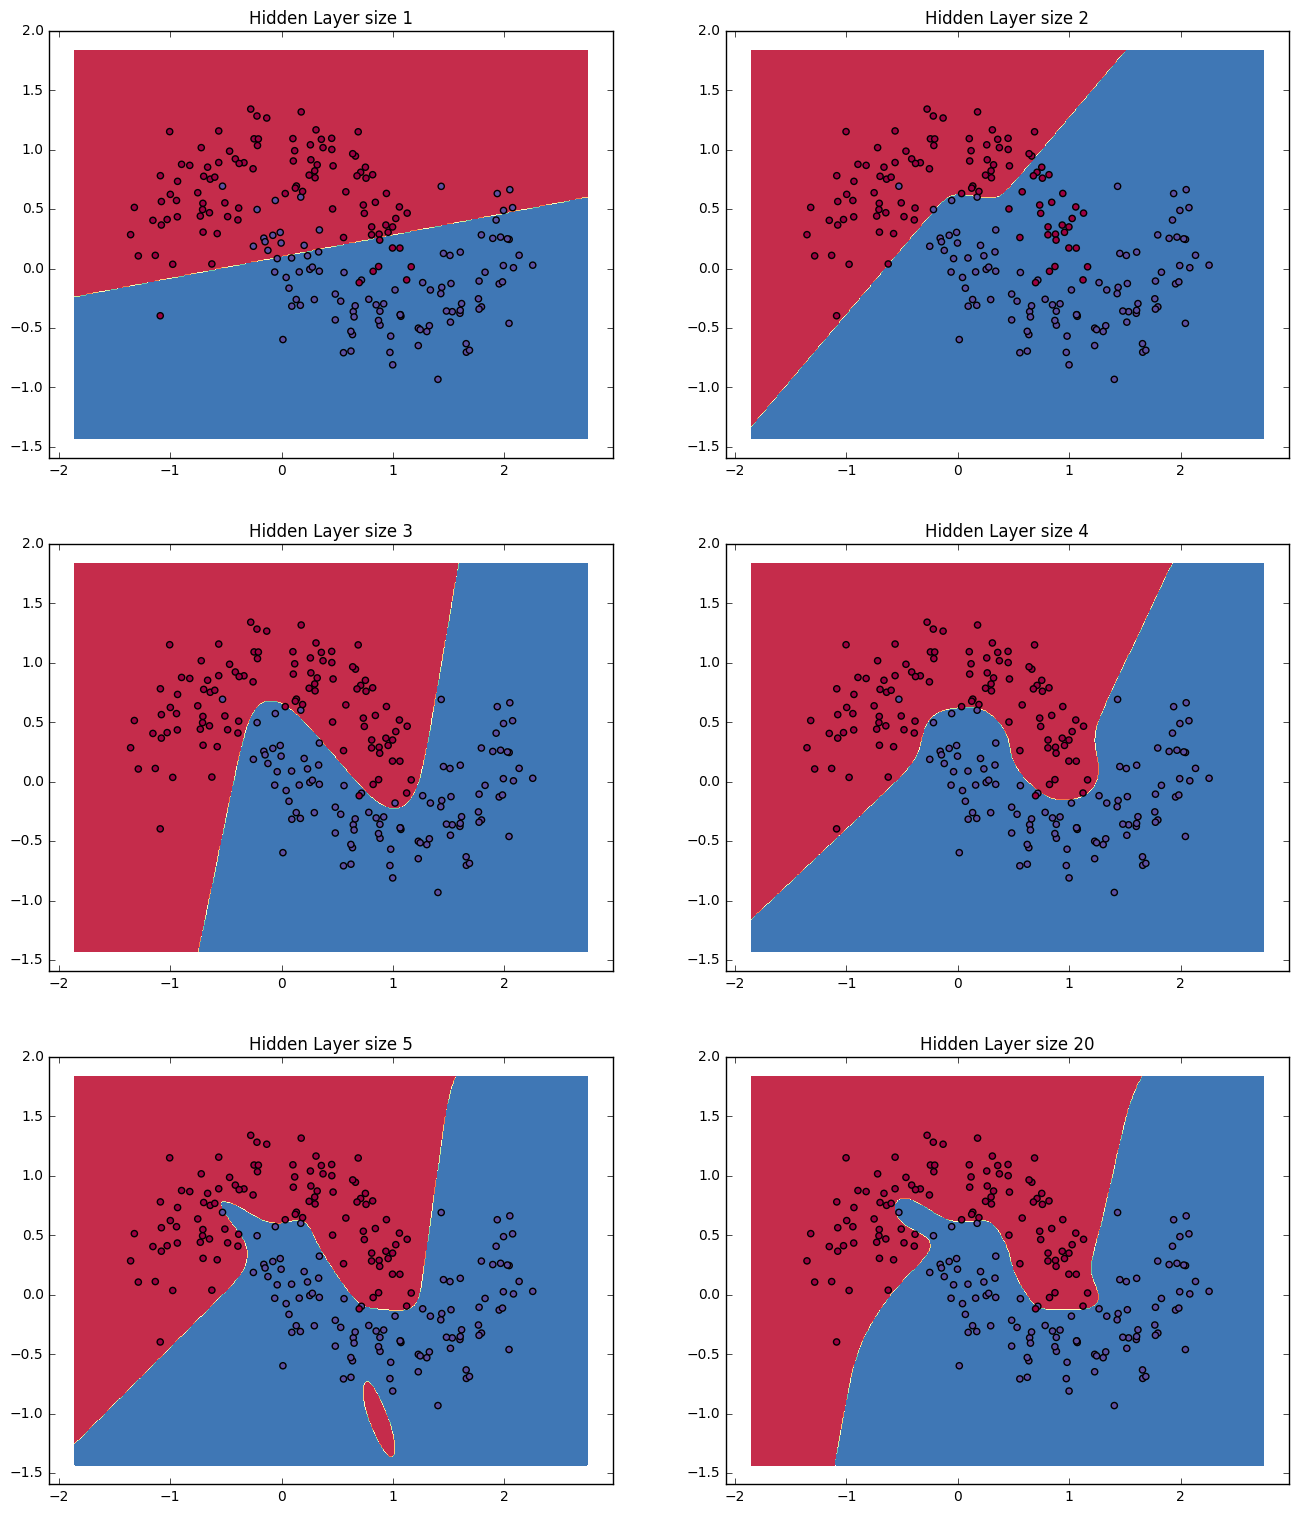

In [7]:
# Helper function to plot a decision boundary.
# If you don't fully understand this function don't worry, it just generates the contour plot below.
def plot_decision_boundary(pred_func):
    # Set min and max values and give it some padding
    x_min, x_max = X[:, 0].min() - .5, X[:, 0].max() + .5
    y_min, y_max = X[:, 1].min() - .5, X[:, 1].max() + .5
    h = 0.01
    # Generate a grid of points with distance h between them
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
    # Predict the function value for the whole gid
    Z = pred_func(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    # Plot the contour and training examples
    plt.contourf(xx, yy, Z, cmap=plt.cm.Spectral)
    plt.scatter(X[:, 0], X[:, 1], c=y, cmap=plt.cm.Spectral)
    
# Helper function to predict an output (0 or 1)
def predict(model, x):
    W1, b1, W2, b2 = model['W1'], model['b1'], model['W2'], model['b2']
    # Forward propagation
    z1 = x.dot(W1) + b1
    a1 = np.tanh(z1)
    z2 = a1.dot(W2) + b2
    exp_scores = np.exp(z2)
    probs = exp_scores / np.sum(exp_scores, axis=1, keepdims=True)
    return np.argmax(probs, axis=1)

# This function learns parameters for the neural network and returns the model.
# - nn_hdim: Number of nodes in the hidden layer
# - num_passes: Number of passes through the training data for gradient descent
# - print_loss: If True, print the loss every 1000 iterations
def build_model(nn_hdim, num_passes=20000, print_loss=False):
     
    # Initialize the parameters to random values. We need to learn these.
    np.random.seed(0)
    W1 = np.random.randn(nn_input_dim, nn_hdim) / np.sqrt(nn_input_dim)
    b1 = np.zeros((1, nn_hdim))
    W2 = np.random.randn(nn_hdim, nn_output_dim) / np.sqrt(nn_hdim)
    b2 = np.zeros((1, nn_output_dim))
 
    # This is what we return at the end
    model = {}
     
    # Gradient descent. For each batch...
    for i in xrange(0, num_passes):
 
        # Forward propagation
        z1 = X.dot(W1) + b1
        a1 = np.tanh(z1)
        z2 = a1.dot(W2) + b2
        exp_scores = np.exp(z2)
        probs = exp_scores / np.sum(exp_scores, axis=1, keepdims=True)
 
        # Backpropagation
        delta3 = probs
        delta3[range(nExamples), y] -= 1
        dW2 = (a1.T).dot(delta3)
        db2 = np.sum(delta3, axis=0, keepdims=True)
        delta2 = delta3.dot(W2.T) * (1 - np.power(a1, 2))
        dW1 = np.dot(X.T, delta2)
        db1 = np.sum(delta2, axis=0)
 
        # Add regularization terms (b1 and b2 don't have regularization terms)
        dW2 += reg_lambda * W2
        dW1 += reg_lambda * W1
 
        # Gradient descent parameter update
        W1 += -epsilon * dW1
        b1 += -epsilon * db1
        W2 += -epsilon * dW2
        b2 += -epsilon * db2
         
        # Assign new parameters to the model
        model = { 'W1': W1, 'b1': b1, 'W2': W2, 'b2': b2}
         
        # Optionally print the loss.
        # This is expensive because it uses the whole dataset, so we don't want to do it too often.
        if print_loss and i % 1000 == 0:
            print "Loss after iteration %i: %f" %(i, calculate_loss(model))
     
    return model

plt.figure(figsize=(16, 32))
hidden_layer_dimensions = [1, 2, 3, 4, 5, 20]
for i, nn_hdim in enumerate(hidden_layer_dimensions):
    plt.subplot(5, 2, i+1)
    plt.title('Hidden Layer size %d' % nn_hdim)
    model = build_model(nn_hdim)
    plot_decision_boundary(lambda x: predict(model, x))
plt.show()